# XGBoost

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

from skopt import forest_minimize  # Random forest hyperparameter optimization
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import DeltaYStopper

# Project level modules
import modules.preprocessing_functions as ppf
import modules.save_model as sm

In [8]:
# Random State
rs = 99

## Functions

In [9]:
def load_and_process(csv_path: 'str', time_period: 'str'):
    """
    Load the csv, process NAN values in the target variable, and
    drop irrelevant rows
    
    Parameters
    ----------
    csv_path : string
    time_period : string 'week', 'month'
    
    Returns
    -------
    df : Pandas Dataframe
    """
    
    # Load csv and parse the first column as dates
    df = pd.read_csv(csv_path, parse_dates=[0])
    
    # Filter time period
    if time_period == 'week':
        df = df[((df['fl_date'] >= f'2018-01-01') &
                (df['fl_date'] <= f'2018-01-07')) |
                ((df['fl_date'] >= f'2019-01-01') &
                 (df['fl_date'] <= f'2019-01-07')) |
                ((df['fl_date'] >= f'2020-01-01') &
                 (df['fl_date'] <= f'2020-01-07'))
               ]
    
    # Set NAN values in departure and arrival delay to 0
    df = ppf.process_nan_values(
        df=df,
        features_to_zero=['dep_delay', 'arr_delay']
    )
    
    # Drop flight rows that were cancelled or diverted
    df = df[
        (df['cancelled'] == 0) &
        (df['diverted'] == 0)
    ]
    
    # Drop flights with delay >+3std and <-120min
    df = df[
        (df['arr_delay'] < (df['arr_delay'].mean()
                            + 3 * df['arr_delay'].std())) &
        (df['arr_delay'] > -120)
    ]
    
    # Add stratifier
    df['is_delayed'] = 0
    df.loc[(df['arr_delay'] > 0), 'is_delayed'] = 1
    
    return df

In [10]:
def performance_stats(feature: 'str', groupby: 'str'):
    """
    
    """
    google_drive_path = ('~/Google Drive/My Drive/Lighthouse Labs/'
                         + 'Mid-term Project/Data-Jan/')
    
    files = {
        '2018' : google_drive_path + '2018-01.csv',
        '2019' : google_drive_path + '2019-01.csv'
    }
    
    
    frames = []

    for yr, file in files.items():
        data = load_and_process(csv_path=file, time_period='month')
        
        date_filters = {
            # First week of January
            'week' : ((data['fl_date'] >= f'{yr}-01-01') &
                (data['fl_date'] <= f'{yr}-01-07')),
            # Month of January
            'month' : ((data['fl_date'] >= f'{yr}-01-01') &
                (data['fl_date'] <= f'{yr}-01-31'))
        }
            
        for timeline, date_filter in date_filters.items():
            stats = pd.DataFrame()
            stats[[
                f'{yr}_{timeline}_{groupby}_mean_{feature}', 
                f'{yr}_{timeline}_{groupby}_std_{feature}', 
                f'{yr}_{timeline}_{groupby}_skew_{feature}'
            ]] = (data[date_filter][[feature, groupby]]
                  .groupby(by=[groupby])
                  .agg({feature : ['mean', 'std', 'skew']})
                 )
            
            frames.append(stats)
    
    stats = pd.concat(frames, axis=1)
    
    return stats

In [11]:
def save_stats():
    """
    
    """
    
    feature_dict = {
        'origin' : 'dep_delay',
        'origin_city_name' : 'dep_delay',
        'dest' : 'arr_delay',
        'dest_city_name' : 'arr_delay',
        'tail_num' : 'arr_delay',
        'op_unique_carrier' : 'arr_delay'
    }
    
    for k, v in feature_dict.items():
        stats = performance_stats(feature=v, groupby=k)
        stats.to_csv(f'../data/feature_average_delay_stats/{k}_{v}_stats.csv')
    
    return None

In [12]:
def week_month(df, time_period: 'str' = 'week'):
    """
    
    Parameters
    ----------
    df : Pandas DataFrame
    time_period : string 'week', 'month'
        
    Returns
    -------
    df : Pandas DataFrame
    """
    
    feature_dict = {
        'origin' : 'dep_delay',
        'origin_city_name' : 'dep_delay',
        'dest' : 'arr_delay',
        'dest_city_name' : 'arr_delay',
        'tail_num' : 'arr_delay',
        'op_unique_carrier' : 'arr_delay'
    }
    
    for k, v in feature_dict.items():
        stats = pd.read_csv(
            f'../data/feature_average_delay_stats/{k}_{v}_stats.csv',
            index_col=[0]
        )
        
        df[f'{k}_{time_period}_mean_{v}'] = (
            df[k].map(stats[f'2018_{time_period}_{k}_mean_{v}'])
        )
    
        df.drop(k, axis=1, inplace=True)
    
    return df

In [13]:
def load(data_set: 'str' = 'sample', time_period: 'str' = 'week'):
    """
    
    Parameters
    ----------
    data_set : string 'full', 'sample'
        'full' is the whole 2019 csv with 638,649 lines
        'sample' is 10,000 lines randomly sampled from 2018-01.csv
    time_period : string 'week', 'month'
    
    Returns
    -------
    data : Pandas DataFrame
    """
    
    google_drive_path = ('~/Google Drive/My Drive/Lighthouse Labs/'
                         + 'Mid-term Project/Data-Jan/')
    
    path = {
        'full' : f'{google_drive_path}2019-01.csv',
        'sample' : f'../data/sample.csv'
    }
    
    # Load the first week of to predict for
    data = load_and_process(csv_path=path[data_set], time_period='week')
    
    # Convert date to day integer
    data['fl_date'] = data['fl_date'].dt.day
    
    # Purge unused columns
    X = ppf.flight_test_features(data, purged=True)
    y = data[['arr_delay', 'is_delayed']]
    
    # Substitue mean delay values for categorical features
    X = week_month(df=X, time_period=time_period)
    
    # For flights of the first week on Jan 2019 that did not fly in the
    # month of 2018, set tail number mean to carrier mean
    X['tail_num_month_mean_arr_delay'].fillna(
        X['op_unique_carrier_month_mean_arr_delay'],
        inplace=True
    )
    
    # set nan to mean
    X = ppf.process_nan_values(
        df=X,
        features_to_mean=[
            'origin_month_mean_dep_delay',
            'dest_month_mean_arr_delay',
            'tail_num_month_mean_arr_delay',
            'op_unique_carrier_month_mean_arr_delay'
        ]
    )
    
    # Drop highly correlated features
    X.drop(['crs_dep_time',
            f'origin_city_name_{time_period}_mean_dep_delay',
            f'dest_city_name_{time_period}_mean_arr_delay'],
           axis=1,
           inplace=True)
    
    return X, y
    

In [14]:
data = load(data_set='full', time_period='month')

<AxesSubplot:>

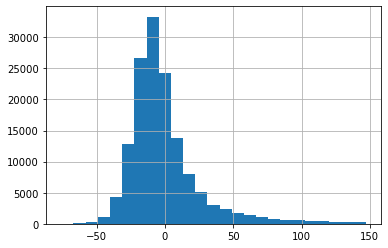

In [13]:
data['arr_delay'].hist(bins=25)

In [15]:
X, y = load(data_set='full', time_period='month')

<AxesSubplot:>

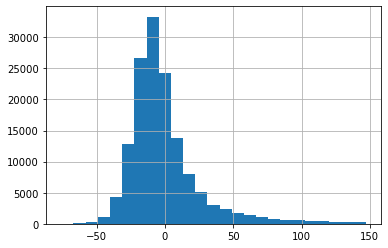

In [19]:
y['arr_delay'].hist(bins=25)

In [13]:
# The time period of the averages being used needs to mach the time period of
# the data being trained. i.e. first week. 56,957 planes flew in january that
# did not fly in the first week. This mismatch leads to NANs galore.

In [9]:
X

,fl_date,crs_arr_time,distance,origin_month_mean_dep_delay,dest_month_mean_arr_delay,tail_num_month_mean_arr_delay,op_unique_carrier_month_mean_arr_delay
0,1,2248,442,7.383641,1.644330,-5.102804,-6.075437
1,1,2357,2475,3.712522,-1.290522,-11.301205,-7.776886
2,1,1605,763,4.151080,-5.567066,-4.138889,-7.776886
3,1,2309,763,4.151080,-5.567066,-11.062500,-7.776886
4,1,757,2475,3.712522,-1.290522,-2.909091,-7.776886
...,...,...,...,...,...,...,...
143052,7,1256,257,6.080777,4.134328,12.127517,6.123259
143053,7,1457,507,7.059851,0.812602,8.146341,6.123259
143054,7,1715,507,5.919394,-0.653183,8.146341,6.123259
143055,7,1605,479,8.867728,2.790318,15.367188,6.123259


In [10]:
X.isna().sum()

fl_date                                   0
crs_arr_time                              0
distance                                  0
origin_month_mean_dep_delay               0
dest_month_mean_arr_delay                 0
tail_num_month_mean_arr_delay             0
op_unique_carrier_month_mean_arr_delay    0
dtype: int64

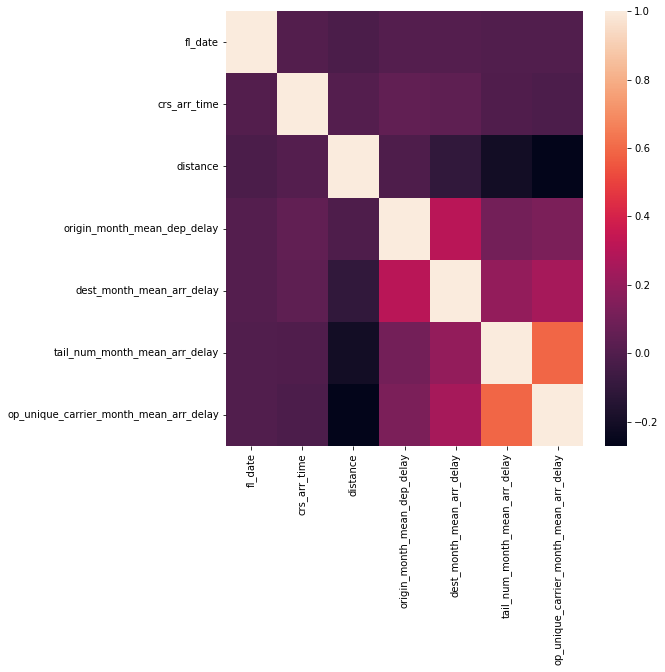

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(X.corr())
plt.show()

## Data Split

## Preprocessing

In [13]:
# NA replacement
# Convert categorical features to numerical
# For numeric
# Scale and transform

### Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y['arr_delay'],
    train_size=0.8,
    test_size=0.2,
    stratify=y['is_delayed'],
    random_state=rs
)

# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

# y_train.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)

<AxesSubplot:>

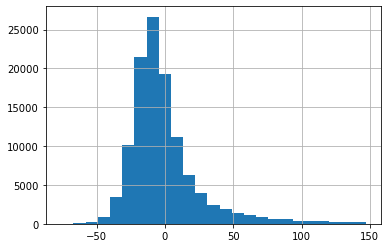

In [25]:
y_train.hist(bins=25)

### Numerical

In [17]:
# Scale numeric features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X=X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X=X_test),
    columns=X_test.columns
    )
X_train_scaled

,fl_date,crs_arr_time,distance,origin_month_mean_dep_delay,dest_month_mean_arr_delay,tail_num_month_mean_arr_delay,op_unique_carrier_month_mean_arr_delay
0,0.000000,0.264277,0.509895,0.467510,0.391697,0.282289,0.490234
1,0.666667,0.518549,0.202948,0.526787,0.513867,0.279366,0.442119
2,0.666667,0.598583,0.217286,0.611381,0.419763,0.219785,0.106616
3,0.333333,0.934139,0.219507,0.651451,0.456480,0.322226,0.335705
4,0.666667,0.687370,0.122779,0.499084,0.431164,0.351513,0.442119
...,...,...,...,...,...,...,...
114440,0.000000,0.430596,0.155493,0.651451,0.448000,0.326324,0.429781
114441,0.000000,0.810338,0.039580,0.433023,0.448000,0.344727,0.740736
114442,0.666667,0.375156,0.143578,0.582566,0.494449,0.368978,0.335705
114443,0.833333,0.961651,0.031099,0.593080,0.620260,0.281304,0.335705


In [13]:
sm.jar(scaler, 'xgboost_scaler')

## Training

### Default

[XGBoost.train](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgboost%20train#xgboost.train)

>```Python
xgb.train(params, dtrain, num_boost_round=10,  
evals=(), obj=None, feval=None,  
maximize=None, early_stopping_rounds=None, evals_result=None,  
verbose_eval=True, xgb_model=None, callbacks=None)```

[XGBRegressor().fit](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=fit#xgboost.XGBRegressor.fit)

>```Python
xgb.XGBRegressor().fit(X, y, *,  
sample_weight=None, base_margin=None, eval_set=None,  
eval_metric=None, early_stopping_rounds=None, verbose=True,  
xgb_model=None, sample_weight_eval_set=None, base_margin_eval_set=None,  
feature_weights=None, callbacks=None)```


In [27]:
X_train_scaled.shape, y_train.shape

((114445, 7), (114445,))

In [43]:
xg_reg_default = xgb.XGBRegressor(random_state=rs)  # rs
xg_reg_default.fit(X=X_train_scaled, y=y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=99,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
y_pred_default = xg_reg_default.predict(X_test_scaled)

In [45]:
# Root mean squared error
rmse = mean_squared_error(
    y_true=y_test,
    y_pred=y_pred_default,
    squared=False
)
print(f'RMSE: {rmse}')

RMSE: 23.96008296210779


In [46]:
y_pred_df = pd.DataFrame(y_pred_default)

In [47]:
y_pred_df.skew()

0    1.028491
dtype: float32

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

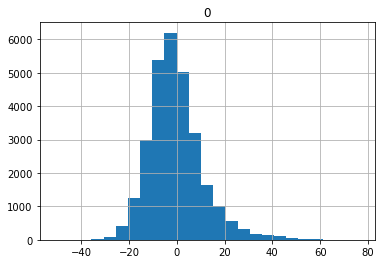

In [48]:
y_pred_df.hist(bins=25)

<BarContainer object of 7 artists>

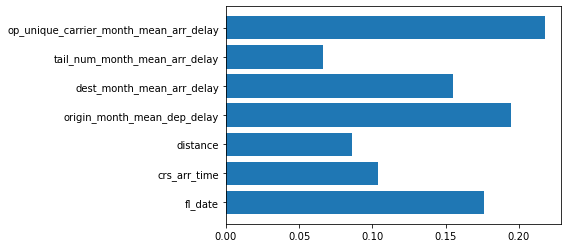

In [49]:
plt.barh(X_train_scaled.columns, xg_reg_default.feature_importances_)

## Grid Search

In [ ]:
params = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [3, 6, 10],
    'learning_rate' : [0.01, 0.1, 0.3, 0.5],
    'objective' : 'reg:squarederror',
    'gamma' : [0, 0.1, 0.2]
    'reg_lambda' : ,
    'random_state'=rs
}

In [ ]:
GS = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=params,
    n_jobs=-1
)

## Forest Minimize

In [23]:
reg = xgb.XGBRegressor(random_state=rs)

space = space = [
    Real(1e-3, 1e0, prior='log-uniform', name='learning_rate'),
    Integer(10, 100, name='n_estimators'),
    Integer(1, 10, name='max_depth'),
    Real(1, 6., name='min_child_weight'),
    Real(0, 0.5, name='gamma'),
    Real(0.5, 1., name='subsample'),
    Real(0.5, 1., name='colsample_bytree'),
    Real(0, 5., name='reg_lambda'),  #  L2 regularization
    Real(0, 5., name='reg_alpha'),  #  L1 regularization
]

In [24]:
@use_named_args(space)
def tune_xgbr(**params):
    # Implementation from Pedro Couto (https://www.kaggle.com/general/17120)
    """
    Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters
    ----------
    Tuples with information about the range that the optimizer should
    use for that parameter, as well as the behaviour that it should
    follow in that range.

    Returns
    -------
    float : the metric that should be minimized.
        If the objective is maximization, then the negative of the
        desired metric must be returned. e.g. AUC for classifiers
    """
    
    reg.set_params(**params)

    print(params)

    #Cross-Validation in order to avoid overfitting
    rmse = -cross_val_score(
        estimator=reg,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='neg_root_mean_squared_error'
    )

    # as the function is minimization (forest_minimize)
    return rmse.mean()

In [25]:
result = forest_minimize(
    func=tune_xgbr,
    dimensions=space,
    n_calls=10,  # default=100
    n_initial_points=10,  # default=10
    random_state=rs,
    verbose=True,
    callback=[DeltaYStopper(delta=0.0001, n_best=5)],
    n_jobs=-1
)

Iteration No: 1 started. Evaluating function at random point.
{'learning_rate': 0.14710215098785087, 'n_estimators': 50, 'max_depth': 10, 'min_child_weight': 4.670313024202228, 'gamma': 0.35050452801603815, 'subsample': 0.5966565518290453, 'colsample_bytree': 0.9886740308166388, 'reg_lambda': 2.888631561647941, 'reg_alpha': 2.568831443437465}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 20.1274
Function value obtained: 23.9196
Current minimum: 23.9196
Iteration No: 2 started. Evaluating function at random point.
{'learning_rate': 0.3585551831180751, 'n_estimators': 69, 'max_depth': 7, 'min_child_weight': 2.3694684113102813, 'gamma': 0.3203007220381459, 'subsample': 0.7468078378369938, 'colsample_bytree': 0.6683861536120936, 'reg_lambda': 3.0816090254282225, 'reg_alpha': 1.8025363226963689}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.5499
Function value obtained: 24.1218
Current minimum: 23.9196
Iteration No: 3 started. Evaluating functi

In [28]:
result

[0.14710215098785087,
 50,
 10,
 4.670313024202228,
 0.35050452801603815,
 0.5966565518290453,
 0.9886740308166388,
 2.888631561647941,
 2.568831443437465]

Test 1
```Python
{'learning_rate': 0.001427327650456945, 'n_estimators': 45, 'max_depth': 6, 'min_child_weight': 5.577312494899226, 'gamma': 0.46958871144265596, 'subsample': 0.9187467962876275, 'colsample_bytree': 0.7163946675955536, 'reg_lambda': 3.580564759611335, 'reg_alpha': 4.256719953358928}
```

Test 2
```Python
{'learning_rate': 0.14710215098785087, 'n_estimators': 50, 'max_depth': 10, 'min_child_weight': 4.670313024202228, 'gamma': 0.35050452801603815, 'subsample': 0.5966565518290453, 'colsample_bytree': 0.9886740308166388, 'reg_lambda': 2.888631561647941, 'reg_alpha': 2.568831443437465}
```

## Train optimized model

In [50]:
# See documentation for all XGBoost parameters
# https://xgboost.readthedocs.io/en/stable/parameter.html

# typical values from
# 1. https://machinelearningmastery.com/xgboost-for-regression/
# 2. https://www.analyticsvidhya.com/blog/2016/03/
#        complete-guide-parameter-tuning-xgboost-with-codes-python/


# Tree Booster Parameters
# learning_rate default 0.3 range [0, 1]
# n_estimators numer of trees
# max_depth default 6 typical 1–10
# colsample_bytree default 1 range (0, 1]
# lambda # L2 regularization default 1
# alpha # L1 regularization default 0
# Use both lambda and alpha for Elastic Net Regression
booster_parameters = {
    'learning_rate': 0.14710215098785087,
    'n_estimators': 50, 
    'max_depth': 10, 
    'min_child_weight': 4.670313024202228, 
    'gamma': 0.35050452801603815, 
    'subsample': 0.5966565518290453, 
    'colsample_bytree': 0.9886740308166388, 
    'reg_lambda': 2.888631561647941, 
    'reg_alpha': 2.568831443437465
}

# Learning Task Parameters
learning_parameters = {
    'objective' : 'reg:squarederror',  # default reg:squarederror
    'eval_metric' : 'rmse',  # regression default 'rmse'
    "seed" : rs  # random seed
}

op = booster_parameters | learning_parameters

In [51]:
# SKlearn wrapper
xg_reg = xgb.XGBRegressor(
    learning_rate=op['learning_rate'],
    n_estimators=op['n_estimators'],
    max_depth=op['max_depth'],
    min_child_weight=op['min_child_weight'],
    gamma=op['gamma'],
    subsample=op['subsample'],
    colsample_bytree = op['colsample_bytree'],
    reg_lambda=op['reg_lambda'],
    reg_alpha = op['reg_alpha'],
    objective=op['objective'],
    eval_metric=op['eval_metric'],
    seed=op['seed'],
)

In [52]:
xg_reg.fit(X=X_train_scaled, y=y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9886740308166388,
             enable_categorical=False, eval_metric='rmse',
             gamma=0.35050452801603815, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.14710215098785087,
             max_delta_step=0, max_depth=10, min_child_weight=4.670313024202228,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=99,
             reg_alpha=2.568831443437465, reg_lambda=2.888631561647941,
             scale_pos_weight=1, seed=99, subsample=0.5966565518290453,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Load model

In [18]:
# load model from file
xg_reg = pickle.load(open('models/flight_delay_xgboost.pickle.dat', 'rb'))

## Validating First week of 2019

In [19]:
y_pred_2019 = xg_reg.predict(X_test_scaled)

In [20]:
# Root mean squared error
rmse = mean_squared_error(
    y_true=y_test,
    y_pred=y_pred_2019,
    squared=False
)
print(f'RMSE: {rmse}')

RMSE: 23.9360998038771


In [50]:
y_pred_2019.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [25]:
diff = pd.DataFrame(y_pred_2019 - y_test)

In [57]:
diff.describe()

,arr_delay
count,28612.000000
mean,0.105109
std,23.936287
min,-182.976204
25%,-7.068812
50%,4.469257
75%,13.814146
max,68.693259


In [62]:
diff[diff['arr_delay'] < -10].describe()

,arr_delay
count,5999.000000
mean,-34.384654
std,27.377721
min,-182.976204
25%,-43.368650
50%,-23.745205
75%,-15.342618
max,-10.001238


In [58]:
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('tab10')

Text(0.5, 1.0, '(ŷ − y) in minutes')

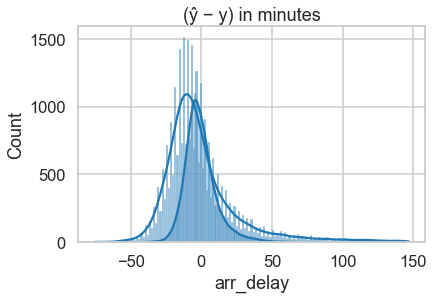

In [60]:
fig, ax = plt.subplots()
fig.tight_layout()
ax = sns.histplot(y_pred_2019, kde=True)
ax = sns.histplot(y_test, kde=True)
ax.get_legend()
plt.title('(ŷ − y) in minutes')
# plt.savefig('xgboost.png', transparent=True)

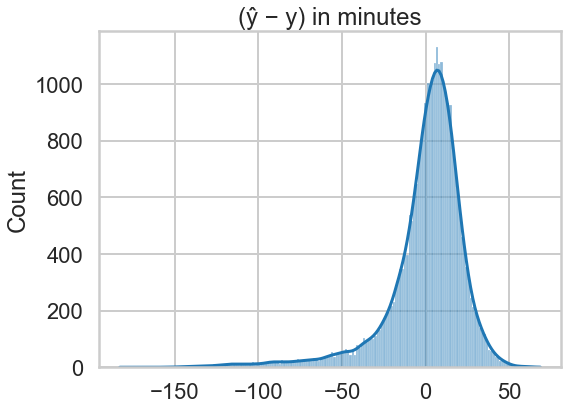

In [65]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8, 6))
fig.tight_layout()
ax = sns.histplot(diff, kde=True)
ax.get_legend().remove()
plt.title('(ŷ − y) in minutes')
plt.savefig('xgboost_y_pred-y.png', transparent=False)

In [52]:
y_pred_df = pd.DataFrame(y_pred_2019)
y_pred_df.describe()

,0
count,28612.000000
mean,-0.533469
std,11.221927
min,-40.446140
25%,-7.657808
50%,-2.044662
75%,4.721710
max,88.102203


skew 0    1.084949
dtype: float32


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

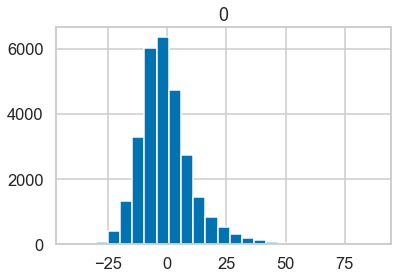

In [53]:
print('skew', y_pred_df.skew())
y_pred_df.hist(bins=25)

<BarContainer object of 7 artists>

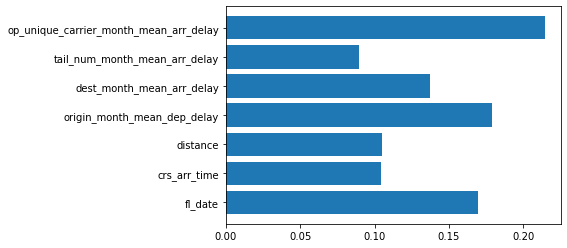

In [58]:
plt.barh(X_test_scaled.columns, xg_reg.feature_importances_)

## Model Evaluation

In [29]:
# Root mean squared error
rmse = mean_squared_error(
    y_true=y_test,
    y_pred=y_pred_default,
    squared=False
)
print(f'RMSE: {rmse}')

RMSE: 23.96008296210779


## Save Model

In [60]:
sm.jar(xg_reg, 'flight_delay_xgboost')